[View in Colaboratory](https://colab.research.google.com/github/Zulkhuu/head-gesture-recogniton/blob/master/python/evaluation/evaluation_colab.ipynb)

# Show system specification

In [0]:
from tensorflow.python.client import device_lib

print("Show System RAM Memory:\n\n")
!cat /proc/meminfo | egrep "MemTotal*"

print("\n\nShow Devices:\n\n"+str(device_lib.list_local_devices()))

Show System RAM Memory:


MemTotal:       13335276 kB


Show Devices:

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8519251622356042964
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 8332476111764249157
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 2020105927275432121
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11276946637
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7311752765523789153
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


# Download Dependencies to Google Colab Environment

This may take several minutes but needs to only be run once per session. Every Google Colab session has temporary storage for assets such as images and other scripts. When the session is closed these objects will be removed but the notebook will remain intact.

*Run the cell below to download necessary dependencies. After this is complete you can navigate to the FILES tab on the left and select refresh - you should see the files listed.*

In [0]:
!pip install PyDrive
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

    100% |████████████████████████████████| 993kB 21.6MB/s 
  Stored in directory: /root/.cache/pip/wheels/fa/d2/9a/d3b6b506c2da98289e5d417215ce34b696db856643bad779f4
Successfully built PyDrive


# Download dataset
Download Face Detection Data Set and Benchmark (FDDB) from Google Drive and unzip.
Original dataset link: http://vis-www.cs.umass.edu/fddb/index.html

In [0]:
# FDDB dataset annotation files id=1HBIPoRFYK763kgOeHG011NAYWdox1Q2Z
download = drive.CreateFile({'id': '1HBIPoRFYK763kgOeHG011NAYWdox1Q2Z'})
download.GetContentFile('FDDB-folds.tgz')
!mkdir -p dataset/FDDB/FDDB-folds
!tar xzf FDDB-folds.tgz -C dataset/FDDB/

# FDDB dataset image files id=1uEv2I4svspLRwvU-nMwQr7ZL1m5RhIYh
download = drive.CreateFile({'id': '1uEv2I4svspLRwvU-nMwQr7ZL1m5RhIYh'})
download.GetContentFile('originalPics.tar.gz')
!mkdir -p dataset/FDDB/originalPics
!tar xzf originalPics.tar.gz -C dataset/FDDB/originalPics/

# Pointing04 dataset image files id=1vClo8TVoAAdlRyn06VHuMB-SlwklAIVP
download = drive.CreateFile({'id': '1vClo8TVoAAdlRyn06VHuMB-SlwklAIVP'})
download.GetContentFile('P04DB.tar.gz')
!mkdir -p dataset/P04DB/originalPics
!mkdir -p dataset/P04DB/P04DB-folds
!tar xzf P04DB.tar.gz -C dataset/P04DB/originalPics/

#Run Face Detection on dataset

In [0]:
!pip install mtcnn
!pip install progressbar2
import cv2
import numpy as np
import pandas as pd
import itertools
import progressbar
import time
import matplotlib.pyplot as plt

    100% |████████████████████████████████| 2.3MB 10.8MB/s 
  Stored in directory: /root/.cache/pip/wheels/be/dd/12/bccde6b95f576af24256f6f1a2e4087eb8488405a6c107e13c
Successfully built mtcnn


In [0]:
!git init head-gesture-recogniton
!cd head-gesture-recogniton ; git remote add origin https://github.com/Zulkhuu/head-gesture-recogniton.git 
!cd head-gesture-recogniton ; git config core.sparsecheckout true
!cd head-gesture-recogniton ; echo "python/head-pose-estimation/*" >> .git/info/sparse-checkout
!cd head-gesture-recogniton ; git pull --depth=1 origin master
!cp head-gesture-recogniton/python/head-pose-estimation/mark_detector.py .
!cp -r head-gesture-recogniton/python/head-pose-estimation/assets .
!rm -r head-gesture-recogniton

Initialized empty Git repository in /content/head-gesture-recogniton/.git/
remote: Enumerating objects: 56, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 56 (delta 6), reused 38 (delta 1), pack-reused 0
Unpacking objects: 100% (56/56), done.
From https://github.com/Zulkhuu/head-gesture-recogniton
 * branch            master     -> FETCH_HEAD
 * [new branch]      master     -> origin/master


In [0]:
from mark_detector import MarkDetector
from mtcnn.mtcnn import MTCNN

detector = MTCNN()
mark_detector = MarkDetector()

#detector_name = 'mtcnn'
detector_name = 'res_ssd'

def face_detect(image,detector_name='mtcnn'):
    """
    input: opencv image
    return: <left_x top_y width height detection_score>
    """
    results = []
    if detector_name == 'mtcnn':
      dets = detector.detect_faces(image)
      for det in dets:
        results.append('{:.6f} {:.6f} {:.6f} {:.6f} {:.6f}'.format(det['box'][0],det['box'][1],det['box'][2],det['box'][3],det['confidence']))
    else:
      facebox = mark_detector.extract_cnn_facebox(image)
      if facebox is not None:
        results.append('{:d} {:d} {:d} {:d} {:d}'.format(facebox[0],facebox[1],facebox[2],facebox[3],10))
    return results

In [0]:
def run_on_P04B(detector_name):
    database_path = 'dataset/P04DB'
    db_image_path = '{:s}/originalPics/P04DB'.format(database_path)
    result_path = '{:s}/P04DB-folds'.format(database_path)
    n_fold = 15
    for i in range(n_fold):
        output_filename = '{:s}/Personne{:02d}-{:s}-result.txt'.format(result_path, i+1, detector_name)
        output_file = open(output_filename,mode='w')
        print('\n\n({:d}/{:d}) Detecting faces from images in Personne{:02d} directory'.format(i+1, n_fold, i+1))
        subfolder_name = '{:s}/Personne{:02d}'.format(db_image_path, i+1)
        
        with progressbar.ProgressBar(maxval=len(os.listdir(subfolder_name))) as bar:
            n = 0
            for image_filename in os.listdir(subfolder_name):
                full_filename = '{:s}/{:s}.jpg'.format(subfolder_name, image_filename.split('.')[0]) 
                #print(image_filename.split('.')[0])
                output_file.write('{:s}\n'.format(full_filename))
                image_cv2 = cv2.imread(full_filename)
                results = face_detect(image_cv2,detector_name)
                output_file.write('{:d}\n'.format(len(results)))
                for result in results:
                    output_file.write('{:s}\n'.format(result))
                n += 1
                bar.update(n)
        '''
            with open(list_filename) as f:
                for image_filename in f:
                    full_filename = '{:s}/{:s}.jpg'.format(db_image_path,image_filename.rstrip())
                    output_file.write(image_filename)
                    image_cv2 = cv2.imread(full_filename)
                    results = face_detect(image_cv2)
                    output_file.write('{:d}\n'.format(len(results)))
                    for result in results:
                        output_file.write('{:s}\n'.format(result))
        '''
        
def parse_p04db_filename(filename):
    #Decode dataset filename
    filename = filename.split('/')[-1].split('.')[0]   
    pid = int(filename[8:10])
    serie = int(filename[10])
    if(filename[14] == '0'):
        vert = int(filename[13:15])
        if(filename[16] == '0'):
            horz = int(filename[15:17])
        else:
            horz = int(filename[15:18])
    else:
        vert = int(filename[13:16])
        if(filename[17] == '0'):
            horz = int(filename[16:18])
        else:
            horz = int(filename[16:19])
    #print('Filename:{:s} Person ID:{:d} Serie{:d} Vert:{:d} Vert:{:d}'.format(filename, pid, serie, vert,horz))
    return pid, serie, vert,horz


In [0]:
run_on_P04B(detector_name)

100% (186 of 186) |######################| Elapsed Time: 0:00:00 ETA:  00:00:00




(1/15) Detecting faces from images in Personne01 directory


AttributeError: ignored


Detection rate over whole dataset:92.87%



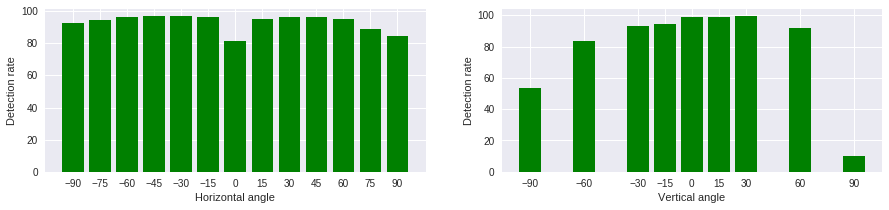

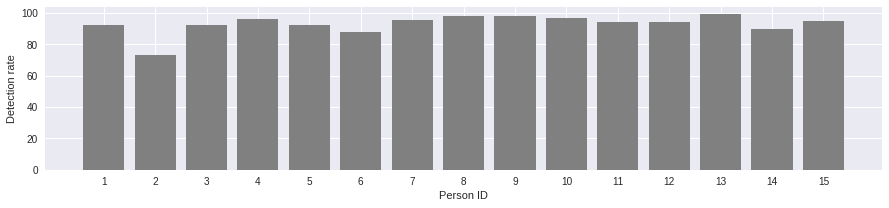

<Figure size 576x396 with 0 Axes>

In [0]:
def show_P04DB_result(detector_name):
    vert_angles = [-90, -60, -30, -15, 0, +15, +30, +60, +90]
    horz_angles = [-90, -75, -60, -45, -30, -15, 0, +15, +30, +45, +60, +75, +90]
    database_path = 'dataset/P04DB'
    result_path = '{:s}/P04DB-folds'.format(database_path)
    results = []
    labels = ['Person ID', 'Series', 'Vertical angle', 'Horizontal angle', 'Number of faces', 'Detection result']
    n_fold = 15
    for i in range(n_fold):
        result_filename = '{:s}/Personne{:02d}-{:s}-result.txt'.format(result_path, i+1, detector_name)
        file = open(result_filename, "r")
        #print ("Name of the file: ", file.name)
        n = 0
        while(n<len(open(result_filename).readlines())):
        #with open(result_filename) as file:
            filename = next(file)
            pid, serie, vert,horz = parse_p04db_filename(filename)
            n += 1
            n_faces = int(next(file))
            n += 1
            det_result = []
            for i in range(n_faces):
                det_result.append(next(file))
                n += 1
            #print(n_faces)
            results.append([pid, serie, vert, horz, n_faces, det_result])
    
    df = pd.DataFrame.from_records(results, columns=labels)
    #detected = df.groupby("Number of faces").filter(lambda x: x.mean() > 0)
    
    result_by_horz_angle = {}
    for horz_angle in horz_angles:
        detected = len(df[(df['Horizontal angle'] == int(horz_angle)) & (df['Number of faces'] == 1)])
        not_detected = len(df[(df['Horizontal angle'] == int(horz_angle)) & (df['Number of faces'] == 0)])
        percentage = 100*detected/(detected + not_detected)
        result_by_horz_angle[horz_angle] = percentage
    #print('\nDetection result by horizontal angle:')
    #for key in result_by_horz_angle:
    #    print('{}:{}'.format(key, result_by_horz_angle[key]))
  
    result_by_vert_angle = {}
    for vert_angle in vert_angles:
        detected = len(df[(df['Vertical angle'] == int(vert_angle)) & (df['Number of faces'] == 1)])
        not_detected = len(df[(df['Vertical angle'] == int(vert_angle)) & (df['Number of faces'] == 0)])
        percentage = 100*detected/(detected + not_detected)
        result_by_vert_angle[vert_angle] = percentage
    #print('\nDetection result by vertical angle:')
    #for key in result_by_vert_angle:
    #    print('{}:{}'.format(key, result_by_vert_angle[key]))

    result_by_personne = {}
    for i in range(n_fold):
        person_id = i+1 #Starts from 1
        detected = len(df[(df['Person ID'] == person_id) & (df['Number of faces'] == 1)])
        not_detected = len(df[(df['Person ID'] == person_id) & (df['Number of faces'] == 0)])
        percentage = 100*detected/(detected + not_detected)
        result_by_personne[person_id] = percentage
    #print('\nDetection result per person')
    #for key in result_by_personne:
    #    print('{}:{}'.format(key, result_by_personne[key]))
        
    detected = len(df[(df['Number of faces'] == 1)])
    not_detected = len(df[(df['Number of faces'] == 0)])
    overall_detection_rate = 100*detected/(detected + not_detected)
    print('\nDetection rate over whole dataset:{:.02f}%\n'.format(overall_detection_rate))
    
    fig, axs = plt.subplots(1,2,figsize=(15,3))
    axs[0].bar(result_by_horz_angle.keys(), result_by_horz_angle.values(), 12, color='g')
    axs[0].set_xticks(horz_angles)
    axs[0].set_xlabel('Horizontal angle')
    axs[0].set_ylabel('Detection rate')
    
    axs[1].bar(result_by_vert_angle.keys(), result_by_vert_angle.values(), 12, color='g')
    axs[1].set_xticks(vert_angles)
    axs[1].set_xlabel('Vertical angle')
    axs[1].set_ylabel('Detection rate')
    
    plt.figure(3,figsize=(15,3))
    plt.bar(result_by_personne.keys(), result_by_personne.values(), color='gray')
    plt.xticks([x+1 for x in range(n_fold)])
    plt.xlabel('Person ID')
    plt.ylabel('Detection rate')
    plt.show()
    plt.tight_layout()
    
show_P04DB_result('res_ssd')

In [0]:
run_on_P04B('mtcnn')


Detection rate over whole dataset:83.85%



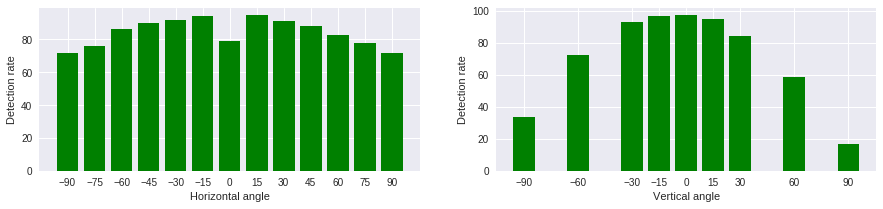

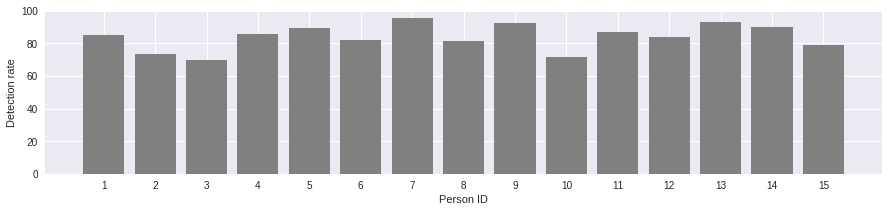

<Figure size 576x396 with 0 Axes>

In [0]:
show_P04DB_result('mtcnn')